In [1]:
!pip3 install box2d-py

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import progressbar
from IPython import display
from torch.autograd import Variable 


In [3]:
class model(nn.Module):
  def __init__(self, input_shape=8, n_layers=5, width=100, n_out=4):
    super(model, self).__init__()
    self.input_shape = input_shape

    """self.layers = nn.ModuleList(
        [nn.Linear(input_shape, width), nn.ReLU()] + \
        [nn.Linear(width, width), nn.Tanh()]*n_layers +\
        [nn.Linear(width, n_out)])
    self.layers = nn.ModuleList(
        [nn.Linear(input_shape, 64), nn.ReLU(), \
        nn.Linear(64, 128), nn.ReLU(), \
        nn.Linear(128, 256), nn.Sigmoid(), \
         nn.Linear(256, n_out)])"""
    
    
    self.layers = nn.ModuleList(
        [nn.Linear(input_shape, 512), nn.ReLU(), \
        nn.Linear(512, 256), nn.Sigmoid(), \
         nn.Linear(256, n_out)])
    
    
  def forward(self, x):
    for lay in self.layers:
      x = lay(x)
    return x

class buffer():
  def __init__(self, size):
    self.size = size
    self.mem = []
    self.pos = 0
  def push(self, e):
    if len(self.mem)<self.size:
      self.mem.append(None)
    self.mem[self.pos] = e
    self.pos = (self.pos + 1)%self.size
  def sample(self, batch_size):
    m = np.array(self.mem)
    return m[np.random.choice(len(self.mem), batch_size)]
  def reset(self):
    self.mem = []
    self.pos = 0
  def __len__(self):
    return len(self.mem)
  def __getitem__(self, e):
    return self.mem[e]


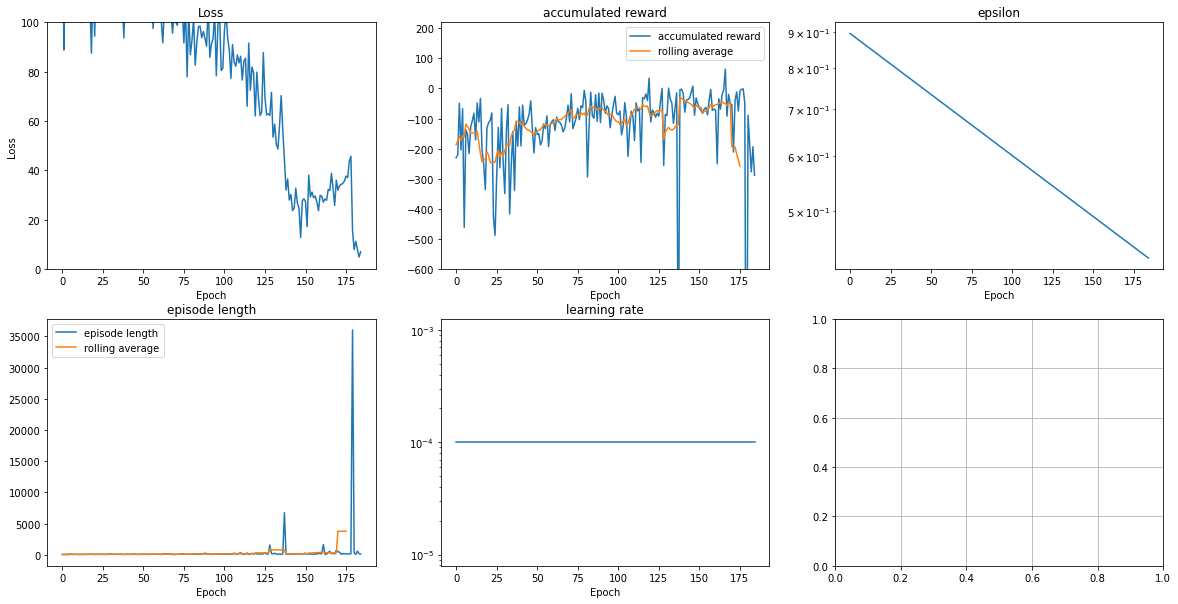

<ipython-input-3-dbdaf553c4f0>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  m = np.array(self.mem)


KeyboardInterrupt: 

In [9]:
env=gym.make('LunarLander-v2').env


batch_size = 64
lr = 0.0001
epochs = 800
gamma=0.99
target = model()
policy = model()
policy.eval()
target.train()
policy.load_state_dict(target.state_dict())


MSE = torch.nn.MSELoss()
optimizer = torch.optim.Adam(target.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=1)

if torch.cuda.is_available():
  device = "cuda"
  print("Using cuda")
else :
  device = "cpu"
  print("Using cpu")
target.to(device)
policy.to(device)

buff = buffer(10000) #4*batch_size)
n_updates = 1
num_clear = 100
K = 1
rs = [] 
losses = []
ep_l = []
epsilon = 0.9
epsilon_decay = 0.996
epsilon_min = 0.01
max_ep_steps = 1000000
bar = progressbar.ProgressBar(maxval=epochs)
bar.start()
bar.update(0)
epsilons = []
lrs = []
for epoch in range(epochs):
  done = False
  s = env.reset()
  epsilon = max(epsilon_decay*epsilon, epsilon_min)
  epsilons.append(epsilon)
  acc_r = 0
  lsss = []
  d_ix = 0
  while not done:
    d_ix += 1
    #select actions with policy net
    st = torch.tensor([s], dtype=torch.float32, device=device)
    
    if np.random.random()<epsilon:
      action = np.random.randint(0, 4)
    else:
      q_vals = policy(st)
      action = np.argmax(q_vals.cpu().detach().numpy())
    
    s_, r, done, _ = env.step(action)
    r /= 1
    acc_r += r
    
    buff.push((s, action, s_, r))

    s = np.copy(s_)
    if d_ix>max_ep_steps:
      break
    if len(buff)>=batch_size: #learn on one batch 
      for _ in range(K):
        tran = buff.sample(batch_size)
        s_batch, a_batch, next_s_batch, r_batch = zip(*tran)
        actions = Variable(torch.from_numpy(np.array(a_batch))).reshape([batch_size, 1]).to(device).type(torch.int64)
        states = Variable(torch.from_numpy(np.array(s_batch))).to(device)
        q_vals_batch = target(states).gather(1, actions) #shape of batch_size, 4
       
        next_values = torch.zeros(batch_size, device=device)
        mask = torch.tensor([s is not None for s in next_s_batch], dtype=torch.bool, device=device)
        next_states_cont = torch.tensor([s for s in next_s_batch if s is not None], device=device)

        next_values[mask] = policy(next_states_cont).max(1)[0].detach()

        r_batch = torch.tensor(r_batch, dtype=torch.float32, device=device).reshape([batch_size, 1])
        
        next_values = next_values.reshape([batch_size, 1])
        lab = gamma*next_values + r_batch
        loss = MSE(q_vals_batch, lab)
        
        lsss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        #for param in target.parameters():
        #  param.grad.data.clamp_(-1, 1)
        optimizer.step()
  
  if epoch<170:
    scheduler.step()
  lrs.append(optimizer.param_groups[0]['lr'])  
  #if epoch%num_clear==0:
    #buff.reset()

  if epoch%n_updates==0:
    policy.load_state_dict(target.state_dict())
  bar.update(epoch + 1)
  rs.append(acc_r)
  ep_l.append(d_ix)
  losses.append(np.mean(lsss))
  if epoch%100==0:
    torch.save(target.state_dict(), f"model_{epoch}")
  if (epoch + 1) % 5 == 0 :
    display.clear_output(wait=True)
    plt.clf()

    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    axs[0, 0].plot(losses)
    axs[0, 0].set_title('Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss') 
    plt.grid(True)
    axs[0, 0].set_ylim([0, 100])

    axs[0, 1].plot(rs)
    axs[0, 1].plot(np.convolve(rs, np.ones(10)/10)[10 - 1 : - 10 + 1])
    axs[0, 1].legend(['accumulated reward', 'rolling average'])
    axs[0, 1].set_title('accumulated reward')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylim([-600, 220])

    axs[0, 2].plot(epsilons)
    axs[0, 2].set_title('epsilon')
    axs[0, 2].set_xlabel('Epoch')
    axs[0, 2].set_yscale("log")

    axs[1, 0].plot(ep_l)
    axs[1, 0].plot(np.convolve(ep_l, np.ones(10)/10)[10 - 1 : - 10 + 1])
    axs[1, 0].legend(['episode length', 'rolling average'])
    axs[1, 0].set_title('episode length')
    axs[1, 0].set_xlabel('Epoch')
    

    axs[1, 1].plot(lrs)
    axs[1, 1].set_title('learning rate')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_yscale("log")
    plt.grid(True)
    
    display.display(plt.gcf())

  
  #print(losses[-1], rs[-1])

In [11]:
np.save("losses_vs", np.array(losses))
np.save("rewards_vs", np.array(rs))
np.save("eps_vs", np.array(epsilons))
np.save("ep_len_vs", np.array(ep_l))


In [ ]:
policy = model()
policy.load_state_dict(torch.load("model_100"))
device = "cpu"
env=gym.make('LunarLander-v2').env
s = env.reset()
done = False
while not done:
  #select actions with policy net
  st = torch.tensor([s], dtype=torch.float32, device=device)

  q_vals = policy(st)
  action = np.argmax(q_vals.cpu().detach().numpy())
 
  s_, r, done, _ = env.step(action)

  acc_r += r
  if done:
    s_ = None
  display.clear_output(wait=True)
  plt.clf()

  fig = plt.figure(figsize=(15, 15))
  print(env.render())
  fig.imshow(env.render())
  
  display.display(plt.gcf())
  s = np.copy(s_)

NoSuchDisplayException: ignored

<Figure size 432x288 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [ ]:

class lunar_lander():
  def __init__(self, discritization=None):
    self.env=gym.make("Taxi-v3").env

class QLearningAgent(object):
    def __init__(self):
        self.whoami = '903614028'
        self.Q = None
        self.alpha = 0.95
        self.gamma = 0.90
        self.env = None
        self.n_episodes = 50000
        self.epsilon = 0.6
        self.decay = True

    def solve(self):
        """Create the Q table"""
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))

        # TODO: Implement the algorithm
        for e in range(self.n_episodes):
          epsilon = self.get_epsilon(e) if self.decay else self.epsilon
          s = self.env.reset()
          terminal = 0 
          while not terminal:
            a = np.argmax(self.Q[s]) if (np.random.random() > epsilon) else np.random.randint(self.env.action_space.n) 
            s_, r, terminal, _ = self.env.step(a) 
            if terminal:
              self.Q[s_] = 0
            self.Q[s, a] = self.Q[s, a] + self.alpha*(r + self.gamma*np.max(self.Q[s_])- self.Q[s, a]) 
            s = s_
    def get_epsilon(self, episode):
      if episode<=0.5*self.n_episodes:
        return self.epsilon
      elif episode>0.5*self.n_episodes and episode<0.75*self.n_episodes:
        return self.epsilon/2
      else:
        return self.epsilon/4


In [ ]:
env=gym.make('LunarLander-v2').env
env.action_space, env.observation_space
s = env.reset()
s

array([-9.5748901e-04,  1.4186655e+00, -9.7002640e-02,  3.4424251e-01,
        1.1163314e-03,  2.1972556e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)